In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import h5py as h5
import itertools
import cmfpy as cmf

%matplotlib inline

### Parameters

In [2]:
PATH = "../figures/sweep/"
noise_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
sparsity_levels = [0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.97, 0.99, 0.99]

### Load data

In [3]:
truth_dict = {}
mu_dict = {}
hals_dict = {}
anls_dict = {}

for noise, sparsity in itertools.product(noise_levels, sparsity_levels):
    tag = "_" + str(noise) + "_" + str(sparsity)
    
    # Load truth
    data_f = h5.File(PATH + "data" + tag + ".jld" , "r")
    truth_dict[noise, sparsity] = np.array(data_f["truth"]).T
    data_f.close()
    
    # Load other stuff
    for name, dest in [("MULT", mu_dict), ("HALS", hals_dict), ("ANLS", anls_dict)]:
        alg_f = h5.File(PATH + name + tag + ".h5", "r")
        dest[noise, sparsity] = {
            "W" : np.array(alg_f["W"]).T,
            "H" : np.array(alg_f["H"]).T,
            "time_hist" : np.array(alg_f["time_hist"]),
            "loss_hist" : np.array(alg_f["loss_hist"]),
            "data" : np.array(alg_f["data"]).T
        }
        alg_f.close()

print("Data loaded")

Data loaded


### Compute true losses (against truth)

In [4]:
loss = {
    "mu" : np.zeros((10, 10)),
    "hals" : np.zeros((10, 10)),
    "anls" : np.zeros((10, 10))
}
results = {
    "mu" : mu_dict,
    "hals" : hals_dict,
    "anls" : anls_dict
}

for i, j in itertools.product(range(10), range(10)):
    noise, sparsity = noise_levels[i], sparsity_levels[j]
    
    truth = truth_dict[noise, sparsity]
    for alg in loss.keys():
        W = results[alg][noise, sparsity]["W"]
        H = results[alg][noise, sparsity]["H"]
        
        X_est = cmf.common.cmf_predict(W, H)
        loss[alg][i, j] = la.norm(X_est - truth) / la.norm(truth)

print("Done with loss computations")

Done with loss computations


### Plots!

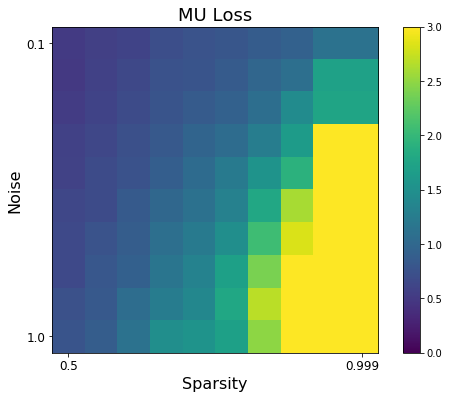

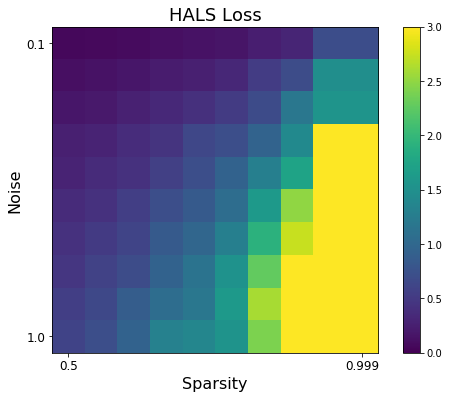

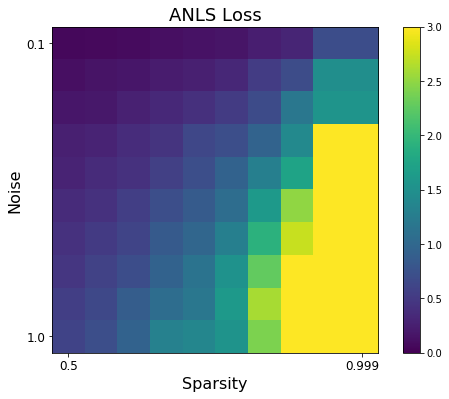

In [5]:
def gen_heatmap(data, clim=None, figsize=(9, 6), title=None, cmap="viridis"):
    plt.figure(figsize=figsize)
    plt.imshow(data, cmap=cmap)
    plt.colorbar()
    plt.xticks([0, 9], [0.5, 0.999], fontsize=12)
    plt.yticks([0, 9], [0.1, 1.0], fontsize=12)
    plt.xlabel("Sparsity", fontsize=16)
    plt.ylabel("Noise", fontsize=16)
    
    if (clim is not None):
        plt.clim(clim)
    if (title is not None):
        plt.title(title, fontsize=18)
    
    plt.show()
    
gen_heatmap(loss["mu"], clim=(0, 3), title="MU Loss")
gen_heatmap(loss["hals"], clim=(0, 3), title="HALS Loss")
gen_heatmap(loss["anls"], clim=(0, 3), title="ANLS Loss")

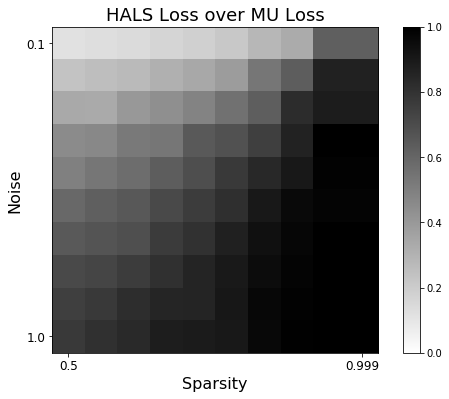

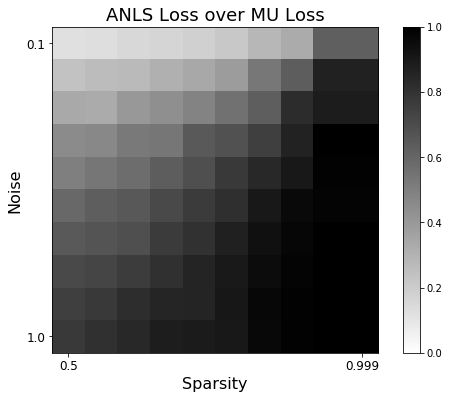

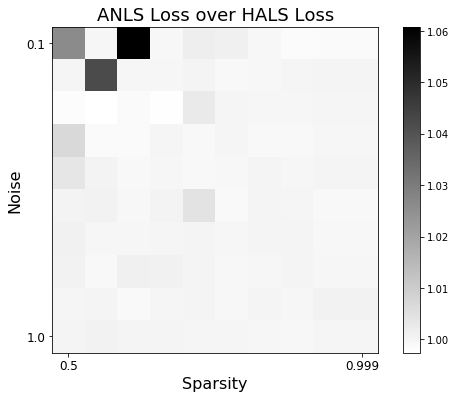

In [6]:
gen_heatmap(
    np.divide(loss["hals"], loss["mu"]),
    clim=(0, 1),
    title="HALS Loss over MU Loss",
    cmap="binary"
)

gen_heatmap(
    np.divide(loss["anls"], loss["mu"]),
    clim=(0, 1),
    title="ANLS Loss over MU Loss",
    cmap="binary"
)

gen_heatmap(
    np.divide(loss["anls"], loss["hals"]),
    clim=None,
    title="ANLS Loss over HALS Loss",
    cmap="binary"
)